# Block VQE by Qubit

Here we will split the Hilbert space into two groups, one which will be calculated classically and the other with will be calculated using block-VQE.  Instead of splitting the Hilbert space into spin-up and spin-down as we did before, here I will split the Hilbert space into general sets of qubits.  

The wavefunction is divided into classical and quantum parts
$$
    |\psi> = \sum_c \alpha_c |c>|\psi_{qc}>
$$
where $|c>$ is a basis state in the classical section and $|\psi_q>$ is the wavefunction in the quantum section.  The weights $\alpha_c$ have to be solved classically while the wavefunctions $|\psi_{qc}>$ will be updated using VQE.  

Let's do a simple X-Y-Z model with closed boundary conditions to test the algorithm.  
$$ 
    H =  \sum_{i} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) 
$$

Let us take the first $N_c$ qubits to be in the classical sector.  Then we can take energy expectation values as,
\begin{equation}
\begin{split}
&<\psi|H|\psi> = \sum_{cc'}\alpha_c\alpha_c'<\psi_{qc'}|<c'| H |c> |\psi_{qc}>=
\\
& \sum_{cc'}\alpha_c\alpha_c' \left( \sum_{i=0}^{N_c-2}  <c'|\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c><\psi_{qc'}|\psi_{qc}>  + \delta_{cc'}\sum_{i=N_c+1}^{N} <\psi_{qc'}| \ \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right) |\psi_{qc}> \right) 
\\
&+ \sum_{cc'}\alpha_c\alpha_c'  \left( <c'|X_{N_c-1}|c><\psi_{qc'}|X_{N_c}|\psi_{qc}> + <c'|Y_{N_c-1}|c> <\psi_{qc'}|Y_{N_c}|\psi_{qc}> + <c'|Z_{N_c-1}|c><\psi_{qc'}|Z_{N_c}|\psi_{qc}> \right) 
\end{split}
\end{equation}

Anything in the classical brakets are calculated classically while anything in the quantum brackets are calculated using quantum hardware.  Notice that some of the quantum brakets are wieghted by classical brackets.  This is not a problem.  

In [41]:
#Only needed if running on the quantum device
from qiskit import IBMQ,transpile
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-afrl', group='air-force-lab', project='quantum-sim')
#backend = provider.get_backend('ibmq_bogota')
backend = provider.get_backend('ibm_lagos')

ibmqfactory.load_account:WARNING:2021-12-09 09:56:11,504: Credentials are already in use. The existing account in the session will be replaced.


## Classical part

### Define Pauli Matrices

Let us define the Pauli matrices so we can do the classical calculations.

In [42]:
import qiskit.quantum_info as qi

def X(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'X'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Y(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Y'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

def Z(i,N):
    label = ['I' for i in range(N)]
    label[i] = 'Z'
    label = ''.join(label)
    return qi.Operator.from_label(label).data

### Generate the states

We need a function which gives you the classical basss for a given number of qubits.

In [43]:
# A function to print the state given the numerical represenations
def bi(num,N):
    bi = bin(num)
    out = []
    Sdiff = N - len(bi) + 2
    for i in range(0,Sdiff):
        out.append(0)
    for i in range(2,len(bi)):
        out.append(int(bi[i]))
    return out

# A function which retruns the numerical representation of states given N
def states(N):
    out = [i for i in range(0,2**N)]
    return out

# A function to print the basis vectors given the number of qubits N
def vecs(N):
    out = []
    for i in range(2**N):
        v = [0 for i in range(2**N)]
        v[i] = 1
        out.append(v)
    return out

In [44]:
import numpy as np

def Mdot(Ol):
    out = Ol[0]
    for i in range(1,len(Ol)):
        out = np.dot(Ol[i],out)
    return out

def bkt(y1,O,y2):
    return Mdot([np.conjugate(y1),O,y2])


### Full Hamiltoniain

Let us write the un-partitioned Hamiltonain so we can compare to it later.

In [45]:
def H(x,y,z,N):
    h = 0*X(0,N)
    for i in range(0,N-1):
        h += x*Mdot([X(i,N),X(i+1,N)]) + y*Mdot([Y(i,N),Y(i+1,N)]) + z*Mdot([Z(i,N),Z(i+1,N)])
    return h
        
    
import pandas as pd
#pd.DataFrame(H(1,2,3,4))

### Calculating the classical brakets

We can calculate all of the classical brakets before we start VQE.  Once we have the value of each braket we simply store it as a weight for the various quantum brakets.  There are five types of classical brakets we need to calculate.

\begin{equation}
\begin{split}
& T_{c,c'} =  <c'|\sum_{i=0}^{N_c-2}\left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1} + z Z_{i} Z_{i+1}\right)|c> 
\\
& B1^x_{c,c'} =  x<c'|X_{N_c-1}|c>
\\
&B1^y_{c,c'} = y<c'|Y_{N_c-1}|c> 
\\
&B1^z_{c,c'} = z<c'|Y_{N_c-1}|c> 
\end{split}
\end{equation}

In [46]:
def T(x,y,z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    for i in range(0,Nc-1):
        O = x*Mdot([X(i,Nc),X(i+1,Nc)]) + y*Mdot([Y(i,Nc),Y(i+1,Nc)]) + z*Mdot([Z(i,Nc),Z(i+1,Nc)])
        out += bkt(v[cc],O,v[c])
    return out

def Bx(x,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = X(Nc-1,Nc)
    out += bkt(v[cc],x*O,v[c])
    return out

def By(y,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Y(Nc-1,Nc)
    out += bkt(v[cc],y*O,v[c])
    return out

def Bz(z,c,cc,Nc):
    out = 0
    v = vecs(Nc)
    O = Z(Nc-1,Nc)
    out += bkt(v[cc],z*O,v[c])
    return out



We Can use these to rewrite the Hamiltoniain.  I will shift the indicies so $ N_c \rightarrow 0 $.

\begin{equation}
\begin{split}
H_{c,c'}=& T_{c,c'} + \delta_{cc'}\sum_{i=0}^{N_q} \left(x X_{i}X_{i+1} + y Y_{i} Y_{i+1}  + z Z_{i} Z_{i+1}\right) 
\\
&+ \left(B^{1x}_{c,c'}X_{0} + B^{1y}_{c,c'} Y_{0} + B^{1z}_{c,c'} Z_{0} \right)
\end{split}
\end{equation}

In [47]:
from qiskit.opflow.primitive_ops import MatrixOp
from qiskit import quantum_info as qi


def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = tcc*Iq
    h += Bx(x,c,cc,Nc)*X(0,Nq)
    h += By(y,c,cc,Nc)*Y(0,Nq)
    h += Bz(z,c,cc,Nc)*Z(0,Nq)
    if c == cc:
        for i in range(0,Nq-1):
            h += x*Mdot([X(i,Nq),X(i+1,Nq)]) + y*Mdot([Y(i,Nq),Y(i+1,Nq)]) + z*Mdot([Z(i,Nq),Z(i+1,Nq)])
    return h
    
    
#H_quantum(1,1,1,3,2,2,2)

In [48]:
def H_quantum(x,y,z,c,cc,Nc,Nq):
    tcc = T(x,y,z,c,cc,Nc)
    Iq = np.identity(2**Nq)
    h = [MatrixOp(tcc*Iq).to_pauli_op()]
    h.append(MatrixOp(Bx(x,c,cc,Nc)*X(0,Nq)).to_pauli_op())
    h.append(MatrixOp(By(y,c,cc,Nc)*Y(0,Nq)).to_pauli_op())
    h.append(MatrixOp(Bz(z,c,cc,Nc)*Z(0,Nq)).to_pauli_op())
    if c == cc:
        for i in range(0,Nq-1):
            h.append(MatrixOp(x*Mdot([X(i,Nq),X(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(y*Mdot([Y(i,Nq),Y(i+1,Nq)])).to_pauli_op())
            h.append(MatrixOp(z*Mdot([Z(i,Nq),Z(i+1,Nq)])).to_pauli_op())
    return h

In [49]:
from qiskit.opflow import SummedOp, PauliOp

def Blocks(x,y,z,Nc,Nq):
    bks = {}
    Mc = len(states(Nc))
    for c in range(0,Mc):
        for cc in range(0,Mc):
            Op = H_quantum(x,y,z,c,cc,Nc,Nq)
            bks[str(c) + ',' + str(cc)] =  Op
    return bks
        
    

In [50]:
Blocks(1,2,3,2,2)['0,0']

[PauliOp(Pauli('II'), coeff=3.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('II'), coeff=0.0),
 PauliOp(Pauli('ZI'), coeff=3.0),
 PauliOp(Pauli('XX'), coeff=1.0),
 PauliOp(Pauli('YY'), coeff=2.0),
 PauliOp(Pauli('ZZ'), coeff=3.0)]

Let us check that we can rebuild the Hamiltoniain.

In [51]:
Nc = 2
Nq = 3
x = 1
y = 2
z = 3
blocks = Blocks(x,y,z,Nc,Nq)

keys = list(blocks.keys())

bL = len(states(Nc))
size = 2**Nq
H_complete = np.array([[0 for i in range(size*bL)] for j in range(size*bL)])

for bi in range(bL):
    for bj in range(bi,bL):
        key = str(bi) + ',' + str(bj)
        if key  in keys:
            hl = blocks[key]
            block = np.sum(hl).to_matrix()
        else:
            block = np.array([[0.0 for i in range(size)] for j in range(size)])
        for i in range(size):
            for j in range(size):
                H_complete[i + bi*size, j + bj*size] = block[i,j]
                H_complete[i + bj*size, j + bi*size] = block[j,i]
                

<ipython-input-51-ef49c2b99a7a>:24: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bi*size, j + bj*size] = block[i,j]
<ipython-input-51-ef49c2b99a7a>:25: ComplexWarning: Casting complex values to real discards the imaginary part
  H_complete[i + bj*size, j + bi*size] = block[j,i]


In [52]:
np.amax(np.abs(H_complete - np.real(H(x,y,z,Nc+Nq))))

0.0

## Anzats Circuit

Here we define the paramaterized circuit which we will optimize. 

$$ U^b_i = \prod_q R^y_q(\phi_{q0}^b)\prod_{q'}C_{4q',4q'+1}C_{4q'+3,4q'+2}\prod_{q''}C_{4q''+1,4q''+2}C_{4q''+4,4q''+3} $$
$$ U^b = \prod_i U^b_i $$

In [53]:
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister, execute

Q = Nq

### Diagonal Blocks

In [54]:
def Ui(cir_i,phi_i):  
    
    for q in range(0,Q):
        cir_i.ry(phi_i[q],q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

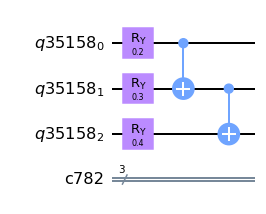

In [55]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst = Ui(cir_i,[0.2,0.3,0.4])

tst.draw(output = 'mpl')

In [56]:
def U(cir,phi_b):
    T = len(phi_b)
    for t in range(T):
        cir = Ui(cir,phi_b[t])
    return cir

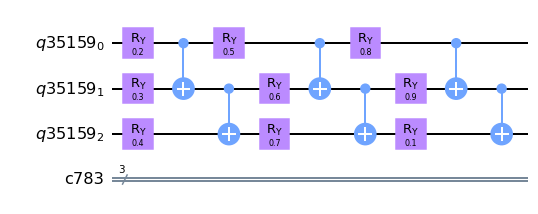

In [57]:
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
tst = U(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]])

tst.draw(output = 'mpl')

### Off Diagonal Blocks

In [58]:
def Ui_off(cir_i,phi_a, phi_b):  
    
    for q in range(0,Q):
        cir_i.ry(phi_a[q],q)
        cir_i.cx(Q,q)
        cir_i.ry(-(phi_b[q]-phi_a[q])/2,q)
        cir_i.cx(Q,q)
        cir_i.ry((phi_b[q]-phi_a[q])/2,q)
    for q in range(0,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    for q in range(1,Q,4):
        cir_i.cx(q,q+1)
        if q + 3 < Q:
            cir_i.cx(q+3,q+2)
    
    return cir_i

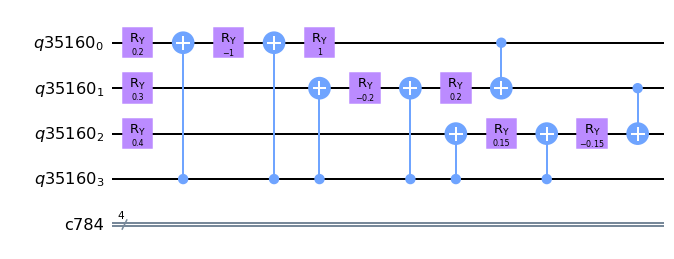

In [59]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
tst = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

tst.draw(output = 'mpl')

In [60]:
#An example block a circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_a = Ui(cir_i,[0.2,0.3,0.4])

#An example block b circuit
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir_i = QuantumCircuit(qr , cr)
tst_b = Ui(cir_i,[2.2,0.7,0.1])

#The combination of the two blocks
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir_i = QuantumCircuit(qr , cr)
cir_i.h(Q)
tst_off = Ui_off(cir_i,[0.2,0.3,0.4],[2.2,0.7,0.1])

print('A:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_a).data)
print('B:')
print(1/np.sqrt(2)*qi.Statevector.from_instruction(tst_b).data)
print('AB:')
print(qi.Statevector.from_instruction(tst_off).data)

A:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j]
B:
[0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]
AB:
[0.68180665+0.j 0.01033899+0.j 0.02088826+0.j 0.01386716+0.j
 0.13820905+0.j 0.00209582+0.j 0.103045  +0.j 0.06840885+0.j
 0.3009187 +0.j 0.21581687+0.j 0.00549678+0.j 0.02958631+0.j
 0.01505849+0.j 0.01079984+0.j 0.1098439 +0.j 0.59123293+0.j]


In [61]:
def U_off(cir,phi_a,phi_b):
    T = len(phi_b)
    cir.h(Q)
    for t in range(T):
        cir = Ui_off(cir,phi_a[t],phi_b[t])
    return cir

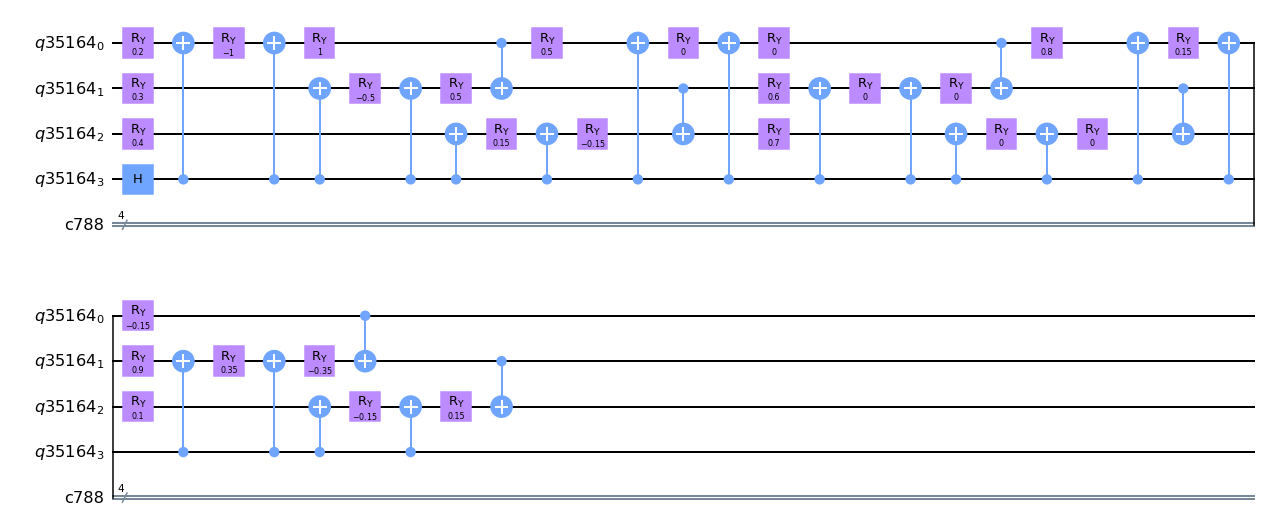

In [62]:
qr = QuantumRegister(Q+1)
cr = ClassicalRegister(Q+1)
cir = QuantumCircuit(qr , cr)
tst = U_off(cir,[[0.2,0.3,0.4],[0.5,0.6,0.7],[0.8,0.9,0.1]],[[2.2,1.3,0.1],[0.5,0.6,0.7],[0.5,0.2,0.4]])

tst.draw(output = 'mpl')

# Calculating E

$$ E = \sum_{ab}<\psi^a|H_{ab}|\psi^b> = \sum_{ab}<000\ldots|U^{\dagger}(\{\phi^a\})H_{ab}U(\{\phi^b\})|000\ldots>$$

each $H_{ab}$ can be brocken down into its Puali components so that $H_{ab} = \sum_p c_p P_{ab,p}$.  Then we have

$$ E = \sum_{ab}\sum_p c_p <000\ldots|U^{\dagger}(\{\phi^a\})  P_{ab,p}U(\{\phi^b\})|000\ldots>$$.

We cannot measure $<\psi^a|P_{ab,p}|\psi^b>$ directly.  Instead we measure $|<\psi^a|P_{ab,p}|\psi^b>|^2$ which tells us nothing about the sign.  

To fix the issue we need to find a way to use the counts to recreate the desired measurement.  This can be done by looking at the counts in each occupation state. 

First we need to go through the circuit and add a $R_y(-\pi/2)$ gate on each qubit where $P_{ab,p}$ applies an X and an $R_x(\pi/2)$ gate to each qubit where $P_{ab,p}$ applies an Y.  This rotates all of the Pauli terms to Z.   Then we can take the count for each occupation state mulitply that count by $(-1)^n$ where n is the number of up qubits with a Puali term in $P_{ab,p}$. 

for example:

\begin{equation}
\begin{split}
<\psi|XZ|\psi> &= <(R_y(\pi/2)\otimes I)\psi|R^{\dagger}_y(\pi/2)XR_y(\pi/2)\otimes Z|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = <(R_y(\pi/2)\otimes I)\psi|ZZ|(R^{\dagger}_y(\pi/2)\otimes I)\psi>
\\
& = |<00|R^{\dagger}_y(\pi/2)\psi>|^2 + (-1)^1|<10|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^1|<01|R^{\dagger}_y(\pi/2) \psi>|^2 + (-1)^2|<11|R^{\dagger}_y(\pi/2) \psi>|^2
\end{split}
\end{equation}

This unfortunetly does not work for $|\psi^a> \neq |\psi_b>$



### Stratagy

In order to run on the quantum device, I would like to group together all of the runs so that each time I measure energy, I only have to que once.  

1) We prepare the circuit to be measured for a given p_label and include measurment instructions.  

2) We collect all of the p_labels from a block into a circuit array

3) We collect all of the blocks into a circuit array

4) we send to the backend

5) we use the measurment instructions to decode the results

6) sum everything together to get the energy

### Prepare the circuits

This is where I left off.

In [63]:
import random

alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#Create an arbitrary collection of rotation angles
T = 1
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            rand = random.random()
            phi_t.append(rand)
        phi_b.append(phi_t)
    phi.append(phi_b)

In [64]:
from qiskit import Aer
from qiskit.visualization import *
from qiskit import quantum_info as qi

def convert_to_circ(p_label,psi0):
    #apply rotations
    psi = copy.deepcopy(psi0)
    pauli_qs = []
    Z_label = ''
    Q = len(p_label)
    for q,p in enumerate(p_label):
        if p == 'X':
            psi.ry(-np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Y':
            psi.rx(np.pi/2,Q-1-q)
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'Z':
            pauli_qs.append(1)
            Z_label += 'Z'
        if p == 'I':
            pauli_qs.append(0)
            Z_label += 'I'       
    #apply measurment 
    psi.measure(psi.qubits,psi.clbits)
    #return circut and measurement instructions
    return [psi,pauli_qs]


#Run a test
import copy
qr = QuantumRegister(Q)
cr = ClassicalRegister(Q)
cir = QuantumCircuit(qr , cr)
psi0 = U(cir,[[1.2,2.3,3.4]])
p_label = blocks['0,0'][7].primitive.to_label()
        
    
cir_tst, lab_tst =  convert_to_circ(p_label,psi0) 
print(p_label)
print(lab_tst)
cir_tst.draw()

IXX
[0, 1, 1]


┌─────────┐     ┌──────────┐            ┌─┐   
q35165_0: ┤ RY(1.2) ├──■──┤ RY(-π/2) ├────────────┤M├───
          ├─────────┤┌─┴─┐└──────────┘┌──────────┐└╥┘┌─┐
q35165_1: ┤ RY(2.3) ├┤ X ├─────■──────┤ RY(-π/2) ├─╫─┤M├
          ├─────────┤└───┘   ┌─┴─┐    └───┬─┬────┘ ║ └╥┘
q35165_2: ┤ RY(3.4) ├────────┤ X ├────────┤M├──────╫──╫─
          └─────────┘        └───┘        └╥┘      ║  ║ 
  c789: 3/═════════════════════════════════╩═══════╩══╩═
                                           2       0  1

### Collect the circuits

In [65]:
#This collects the circuits for the on-diagonal blocks only
def collect_diag_circs(phi_b,block):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi0 = U(cir,phi_b)
    cirs = []
    meas = []
    coef = []
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        if np.abs(w) > 0:
            p_label = p.primitive.to_label()
            cir_p,meas_p  = convert_to_circ(p_label,psi)
            cirs.append(cir_p)
            meas.append(meas_p)
            coef.append(w)
    return cirs,meas,coef

block = blocks['0,0']
phi_b = phi[0]

circs, meas, coefs = collect_diag_circs(phi_b,block)

n=1
print(coefs[n])
print(meas[n])
circs[n].draw()

3.0
[1, 0, 0]


┌─────────────┐          ┌─┐      
q35166_0: ┤ RY(0.14766) ├──■───────┤M├──────
          ├─────────────┤┌─┴─┐     └╥┘┌─┐   
q35166_1: ┤ RY(0.85411) ├┤ X ├──■───╫─┤M├───
          ├─────────────┤└───┘┌─┴─┐ ║ └╥┘┌─┐
q35166_2: ┤ RY(0.17757) ├─────┤ X ├─╫──╫─┤M├
          └─────────────┘     └───┘ ║  ║ └╥┘
  c790: 3/══════════════════════════╩══╩══╩═
                                    0  1  2

In [66]:
# This collects circuits for both on and off diagonal blocks but is unefficient for on-diagonal blocks
def collect_off_circs(phi_a,phi_b,block):
    qr = QuantumRegister(Q+1)
    cr = ClassicalRegister(Q+1)
    cir = QuantumCircuit(qr , cr)
    psi0 = U_off(cir,phi_a,phi_b)
    cirs = []
    meas = []
    coef = []
    for p in block:
        psi = copy.deepcopy(psi0)
        w = p.coeff
        if np.abs(w) > 0.0:
            p_label = p.primitive.to_label()
            circ_x,meas_x = convert_to_circ('X' + p_label,psi)
            circ_y,meas_y = convert_to_circ('Y' + p_label,psi)
            cirs.append(circ_x)
            meas.append(meas_x)
            coef.append(w)
            cirs.append(circ_y)
            meas.append(meas_y)
            coef.append(1j*w)
    return cirs,meas,coef


block = blocks['0,1']
phi_a = phi[0]
phi_b = phi[1]

circs, meas, coefs = collect_off_circs(phi_a,phi_b,block)

n=0
print(coefs[n])
print(meas[n])
circs[n].draw()

1.0
[1, 1, 0, 0]


┌─────────────┐┌───┐┌──────────────┐┌───┐┌─────────────┐»
q35167_0: ┤ RY(0.14766) ├┤ X ├┤ RY(-0.32817) ├┤ X ├┤ RY(0.32817) ├»
          ├─────────────┤└─┬─┘└──────────────┘└─┬─┘└────┬───┬────┘»
q35167_1: ┤ RY(0.85411) ├──┼────────────────────┼───────┤ X ├─────»
          ├─────────────┤  │                    │       └─┬─┘     »
q35167_2: ┤ RY(0.17757) ├──┼────────────────────┼─────────┼───────»
          └────┬───┬────┘  │                    │         │       »
q35167_3: ─────┤ H ├───────■────────────────────■─────────■───────»
               └───┘                                              »
  c791: 4/════════════════════════════════════════════════════════»
                                                                  »
«                                                                   ┌─┐»
«q35167_0: ───────────────────────────────────────────■─────────────┤M├»
«          ┌─────────────┐┌───┐┌──────────────┐     ┌─┴─┐           └╥┘»
«q35167_1: ┤ RY(0.11216) ├┤ X ├┤ RY(-0.11216) ├─────┤ X ├────────────╫─»
«          └─────────────┘└─┬─┘└────┬───┬─────┘┌────┴───┴─────┐┌───┐ ║ »
«q35167_2: ─────────────────┼───────┤ X ├──────┤ RY(-0.39272) ├┤ X ├─╫─»
«                           │       └─┬─┘      └──────────────┘└─┬─┘ ║ »
«q35167_3: ─────────────────■─────────■──────────────────────────■───╫─»
«                                                                    ║ »
«  c791: 4/══════════════════════════════════════════════════════════╩═»
«                                                                    0 »
«                                                
«q35167_0: ──────────────────────────────────────
«                                          ┌─┐   
«q35167_1: ─────────────────■──────────────┤M├───
«          ┌─────────────┐┌─┴─┐┌──────────┐└╥┘┌─┐
«q35167_2: ┤ RY(0.39272) ├┤ X ├┤ RY(-π/2) ├─╫─┤M├
«          └─┬──────────┬┘└┬─┬┘└──────────┘ ║ └╥┘
«q35167_3: ──┤ RY(-π/2) ├──┤M├──────────────╫──╫─
«            └──────────┘  └╥┘              ║  ║ 
«  c791: 4/═════════════════╩═══════════════╩══╩═
«                           3               1  2

In [67]:
# collect all the circuits 
def collect_circs(alpha,phi,blocks):
    circs = []
    meas = []
    coefs = []
    for key in list(blocks.keys()):
        if key[0] == key[2]:
            circ_b, meas_b, coef_b = collect_diag_circs(phi[int(key[0])],blocks[key])
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
        else:
            circ_b, meas_b, coef_b = collect_off_circs(phi[int(key[0])],phi[int(key[2])],blocks[key])
            for b in range(len(coef_b)):
                circs.append(circ_b[b])
                meas.append(meas_b[b])
                coefs.append(alpha[int(key[0])]*alpha[int(key[2])]*coef_b[b])
    return circs, meas, coefs

circs, meas, coefs = collect_circs(alpha,phi,blocks)

n=1
print(len(circs))
print(coefs[n])
print(meas[n])
circs[n].draw()

56
0.75
[1, 0, 0]


┌─────────────┐          ┌─┐      
q35168_0: ┤ RY(0.14766) ├──■───────┤M├──────
          ├─────────────┤┌─┴─┐     └╥┘┌─┐   
q35168_1: ┤ RY(0.85411) ├┤ X ├──■───╫─┤M├───
          ├─────────────┤└───┘┌─┴─┐ ║ └╥┘┌─┐
q35168_2: ┤ RY(0.17757) ├─────┤ X ├─╫──╫─┤M├
          └─────────────┘     └───┘ ║  ║ └╥┘
  c792: 3/══════════════════════════╩══╩══╩═
                                    0  1  2

### Run function

In [68]:
circs, meas, coefs = collect_circs(alpha,phi,blocks)

def get_results(circs, method = 'matrix'):
    if method == 'matrix':
        # add results
        r = []
        for l in range(len(circs)):
            circs[l].remove_final_measurements()
            wave = qi.Statevector.from_instruction(circs[l])
            r_l = wave.probabilities_dict()
            r.append(r_l)
    
    if method == "simulator":
        sim = Aer.get_backend("qasm_simulator")
        r = execute(circs, backend = sim).result().get_counts()
        
    if method == "quantum":
        job = backend.run(transpile(circs, backend), meas_level=2, shots=8192) 
        r = job.result().get_counts()
        
        
    return r

r = get_results(circs, method = 'matrix')
#r = get_results(circs, method = 'simulator')
#r = get_results(circs, method = 'quantum')

### Analyze results

In [69]:
def energy_from_results(r,meas,coefs):
    E = 0
    for l in range(len(r)):
        z_measure = 0
        total = 0
        for key in list(r[l].keys()):
            n = 0
            for q in range(len(key)):
                if key[q] == '1' and meas[l][q] == 1:
                    n += 1
            z_measure += (-1)**n * r[l][key] 
            total += r[l][key]
        E += coefs[l]*z_measure/total
    return np.real(E)

energy_from_results(r,meas,coefs)

5.747181772535851

In [70]:
#Check against H_complete               
wave_full = []
for b in range(bL):
    qr = QuantumRegister(Q)
    cr = ClassicalRegister(Q)
    cir = QuantumCircuit(qr , cr)
    psi_b = U(cir,phi[b])
    wave_b = alpha[b]*qi.Statevector.from_instruction(psi_b).data
    wave_full.append(wave_b)
wave_full = np.array(wave_full).flatten()

np.dot(np.conjugate(wave_full),np.dot(H_complete,wave_full))


(5.747181772535848+0j)

In [71]:
alpha = 1/np.sqrt(bL)*np.array([1 for b in range(bL)])

#number of blocks
T = 2
phi = []
for b in range(bL):
    phi_b = []
    for ti in range(T):
        phi_t = []
        for q in range(Q):
            phi_t.append(0)
        phi_b.append(phi_t)
    phi.append(phi_b)
    
circs, meas, coefs = collect_circs(alpha,phi,blocks)
r = get_results(circs, method = 'matrix')
energy_from_results(r,meas,coefs)

7.0

### Grouping three energies to be run together

In the optimization below we use three energies at each step.  One for the current values and two to define the derivetive.  Since the bottle neck is sending jobs to the device, it will be useful to group these three energies into one job.

In [72]:
def collect_energy_circs(a1, p1, b1, a2, p2, b2, a3, p3, b3):
    circs1, meas1, coefs1 = collect_circs(a1,p1,b1)
    circs2, meas2, coefs2 = collect_circs(a2,p2,b2)
    circs3, meas3, coefs3 = collect_circs(a3,p3,b3)
    L1 = len(circs1)
    L2 = len(circs2)
    L3 = len(circs3)
    circs = circs1+circs2+circs3
    meas = meas1+meas2+meas3
    coefs = coefs1+coefs2+coefs3
    lengths = [L1,L2,L3]
    return circs,meas,coefs,lengths

def three_energies_from_results(r,meas,coefs,lengths):
    L1 = lengths[0]
    L2 = lengths[1]
    L3 = lengths[2]
    r1 = r[0 : L1]
    r2 = r[L1 : L1+L2]
    r3 = r[L1+L2 : L1+L2+L3]
    m1 = meas[0 : L1]
    m2 = meas[L1 : L1+L2]
    m3 = meas[L1+L2 : L1+L2+L3]
    c1 = coefs[0 : L1]
    c2 = coefs[L1 : L1+L2]
    c3 = coefs[L1+L2 : L1+L2+L3]
    E1 = energy_from_results(r1,m1,c1)
    E2 = energy_from_results(r2,m2,c2)
    E3 = energy_from_results(r3,m3,c3)
    return E1,E2,E3
    

In [73]:
circs, meas, coefs, lengths = collect_energy_circs(alpha,phi,blocks,alpha,phi,blocks,alpha,phi,blocks)
r = get_results(circs, method = 'matrix')
E1,E2,E3 = three_energies_from_results(r,meas,coefs,lengths)
print(E1,E2,E3)

7.0 7.0 7.0


# Optimizaition

I will be using the simultaneous perturbation stochastic approximation algorithm.  The algorithm works by calculating the gradiant of the cost function $E(\hat{\phi})$ by randomly purturbating all parameters in $\hat{\phi}$

Let $\hat{\Delta}_k$ be a set of randomly selected purturbations during step $k$ of the algorithm. I will use the Bernoulli distribution to select $\hat{\Delta}_k$.  Then the gradient is 
$$ \hat{g}_k(\hat{\phi}_k) = \frac{E(\hat{\phi}_k + c_k \hat{\Delta}_k)-E(\hat{\phi}_k - c_k \hat{\Delta}_k)}{2 c_k} \hat{\Delta}_k$$.
The gradiant is then used to update the parameters 
$$ \hat{\phi}_{k+1} = \hat{\phi}_k - a_k \hat{g}_k(\hat{\phi}_k) $$

$c_k$ and $a_k$ decrease with each iteration of the algorithm so that we zero in on the the minimum of $E$.  They are given by
$$c_k = \frac{c}{(k+1)^{\gamma}}$$
$$a_k = \frac{a}{(A+k+1)^{\alpha}}$$
where $a$, $A$, $\alpha$, $c$, and $\gamma$ are choosen at the begining of the algorithm.

In [74]:
import copy

In [75]:
#beta = 0.602
beta = 0.201
A = 10
a = 0.05
gamma = 0.101
c = 0.4

beta_a = 0.201
A_a = 10
a_a = 0.05
gamma_a = 0.101
c_a = 0.4

def SPSA(k_max,method = 'simple',hold = False):
    #Initalization
    k = 0
    phi_k = np.array(phi)
    alpha_k = np.array(alpha)
    E_l = []
    hold_l = []
    
    #Begin Iterations
    for k in range(k_max):
        #Update c and a
        a_k = a/((A + k + 1)**beta)
        c_k = c/((k + 1)**gamma)
        a_ak = a_a/((A_a + k + 1)**beta_a)
        c_ak = c_a/((k + 1)**gamma_a)

        #Find Delta
        Delta_k = np.array(phi_k)
        for b in range(bL):
            for t in range(T):
                for q in range(Q):
                    Delta_k[b][t][q] = 1 - 2*np.random.binomial(size=None, n=1, p=0.5)
        phi_k_A = phi_k + c_k*Delta_k
        phi_k_B = phi_k - c_k*Delta_k
        
        #Find Delta Alpha
        Delta_ak = np.array(alpha_k)
        for n in range(bL):
            Delta_ak[n] = 1 - 2*np.random.binomial(size=None, n=1, p= 0.5)
        alpha_k_A = alpha_k + c_ak*Delta_ak
        alpha_k_B = alpha_k - c_ak*Delta_ak
        norm_A = 1/np.sqrt(np.dot(alpha_k_A,alpha_k_A))
        norm_B = 1/np.sqrt(np.dot(alpha_k_B,alpha_k_B))
        alpha_k_A = norm_A*alpha_k_A
        alpha_k_B = norm_B*alpha_k_B
           
        #Find E    
        circs,meas,coefs,lengths = collect_energy_circs(alpha_k_A,phi_k_A,blocks,alpha_k_B,phi_k_B,blocks,alpha_k,phi_k,blocks)
        r = get_results(circs, method = method)
        E_A, E_B, E_f = three_energies_from_results(r,meas,coefs,lengths)

        
        #Calculate gradiant
        g = np.real((E_A-E_B)/(2*c_k)) 
        
        #Update phi
        g_k = g * Delta_k
        phi_k = phi_k - a_k * g_k
        
        #Update alpha
        g_ak = g * Delta_ak
        alpha_k = alpha_k - a_ak * g_ak
        norm = 1/np.sqrt(np.dot(alpha_k,alpha_k))
        alpha_k = norm*alpha_k

        
        #Print and save E
        print(k,E_f)
        #print('k=',k,'c_k=',c_k,'a_k=',a_k,'g=',g,'E_A=',E_A,'E_B=',E_B,'E_f=',E_f)
        E_l.append(E_f)
        
        if hold == True:
            hold_k = {'E':E_f,'c':c_k,'a':a_k,'phi':phi_k,'Delta':Delta_k,'c_a':c_ak,'a_a':a_ak,'alpha':alpha_k,'Delta_a':Delta_ak}
            hold_l.append(hold_k)
    if hold == True:
        return hold_l
    else:
        return E_l,phi_k

In [ ]:
out = SPSA(20,method = 'quantum',hold = True)

0 5.075439453125


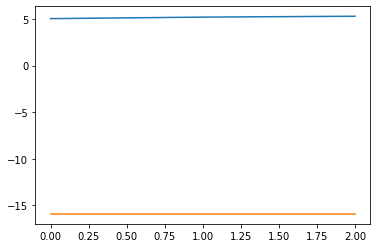

In [77]:
e,y = np.linalg.eig(H_complete)

import matplotlib.pyplot as plt

E0 = [np.sort(e)[0] for i in range(len(out))]

El = [out[i]['E'] for i in range(len(out))]
tl = [i for i in range(len(El))]

plt.plot(tl,El)
plt.plot(tl,E0)